# Data Science Project: Predicting Player Gender on a Minecraft Server

#### Group project-003-13 – Mandy Sui

## 1) Introduction

This project aims to explore whether the amount of time players spend on a Minecraft research server can be used to predict their gender. The dataset was collected by a UBC computer science research team to study player engagement patterns and demographic differences.  
Understanding how playtime relates to gender can provide insights into how different groups interact with online environments. It may also help researchers design more inclusive and engaging experiences for all players.


## 2) Data Description

### Datasets

#### `players.csv`

**Number of Observations:** 196  
**Number of Variables:** 7  

**Variables:**
- `experience`: Player’s experience level (e.g., Pro, Amateur, Veteran)
- `subscribe`: Subscription status (TRUE/FALSE)
- `hashedEmail`: Hashed version of player email (used to link with sessions.csv)
- `played_hours`: Total hours spent playing
- `name`: Player name
- `gender`: Player’s gender
- `age`: Player’s age

#### `sessions.csv`

**Number of Observations:** 1535  
**Number of Variables:** 5  
**Variables:**
- `hashedEmail`: Player ID for session tracking  
- `start_time`: Session start time  
- `end_time`: Session end time  
- `original_start_time`: Numeric timestamp for start time  
- `original_end_time`: Numeric timestamp for end time  

### Potential Issues

- **Missing Values:** Some players may have missing `age` or `played_hours`.  
- **Data Privacy:** The email addresses are hashed for anonymity.  
- **Sampling Bias:** The dataset may not represent all Minecraft players.  

### Potential Confounding Variables

- Experience Level: Players with higher experience levels may play longer hours regardless of gender, which could confound the relationship between gender and playtime.  
- Subscription Status: Subscribed players might spend more time playing due to increased engagement, and subscription rates could differ between genders.  
- Age: Age may influence both the amount of time spent playing and gender distribution patterns.  
Organization Affiliation: Players associated with organizations might show different engagement levels, and these organizations could have gender imbalances.

## 3) Research Question

### Broad Question

How do player behaviors and activity levels relate to their gender?

### Specific Question
Can total hours played (`played_hours`) predict a player’s gener (`gender`)?

#### **Response Variable:**  
- `gender` (categorical — male or female or others)

#### **Explanatory Variable:**  
- `played_hours` (quantitative — total time spent playing)

### Data Wrangling Plan

1. **Import and inspect the datasets** (`players.csv`, `sessions.csv`).  
2. **Filter gender:** Keep only "Male" and "Female" players for the analysis.  
3. **Select relevant variables:** `gender` and `played_hours`.  
4. **Encode `gender` as a factor** with two levels: "Male" and "Female".  
5. **Handle missing values:** Remove or impute missing `played_hours` or `gender` entries.  
6. **Standardize numeric variables:** Scale `played_hours` so KNN distance calculations are correct.  
7. **Split data** into training and testing sets for predictive modeling.

### Predictive Method
- Will use **K-Nearest Neighbors (KNN)** as the primary method for this binary classification problem, predicting a player’s gender based on the total hours they have played on the Minecraft server.

## 4) Exploratory Data Analysis (EDA)

### Data Wrangling

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [31]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [52]:
players_filtered <- players[, c("gender", "played_hours")]

players_filtered$gender <- recode(players_filtered$gender,
                                  "Male" = "Male",
                                  "Female" = "Female",
                                  .default = "Others")


players_filtered$gender <- factor(players_filtered$gender, levels = c("Male", "Female", "Others"))


table(players_filtered$gender)


  Male Female Others 
   124     37     35 

In [46]:
mean_played_hours <- mean(players$played_hours, na.rm = TRUE)
mean_played_hours


[1] 5.845918

In [48]:
mean_age <- mean(players$Age,na.rm = TRUE)
mean_age

[1] 21.13918

### Mean Value for Each Quantitative Variable in the players.csv Data Set
| Variable       | Mean Value |
|----------------|-----------|
| played_hours   | 5.85      |
| age            | 21.14     |


### Exploratory Visualizations

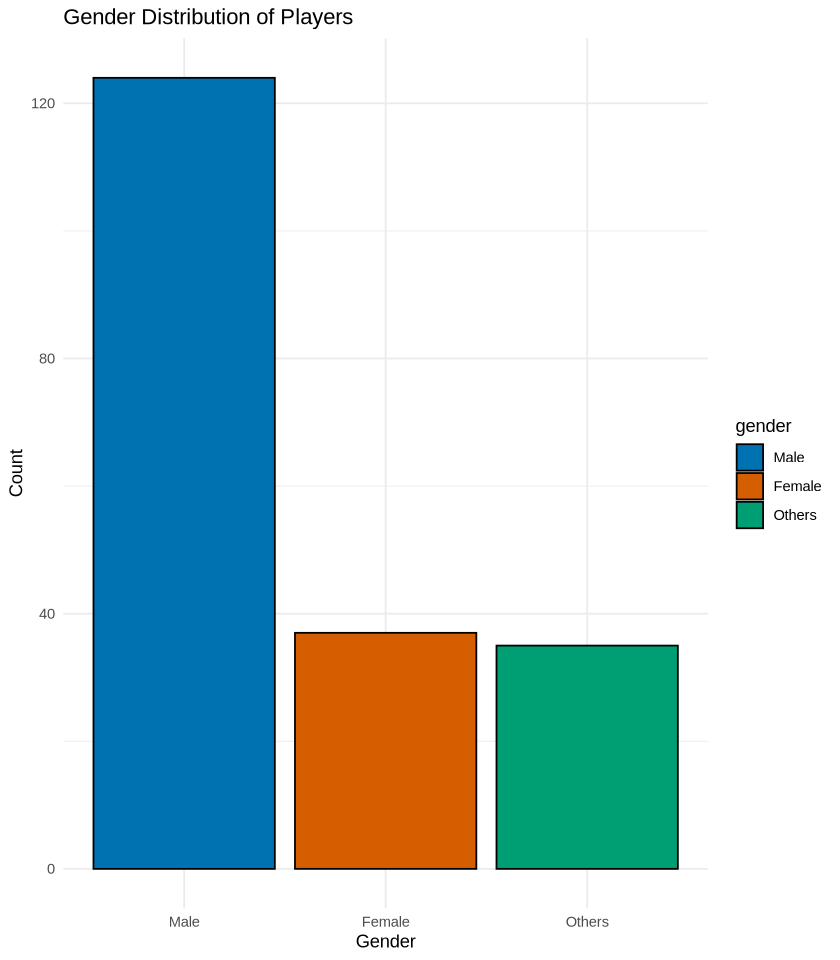

In [58]:
gender_dist <- ggplot(players_filtered, aes(x = gender, fill = gender)) +
  geom_bar(color = "black") +
  scale_fill_manual(values = c("Male" = "#0072B2",   
                               "Female" = "#D55E00", 
                               "Others" = "#009E73"))+ 
  labs(title = "Gender Distribution of Players",
       x = "Gender",
       y = "Count") +
  theme_minimal()

gender_dist

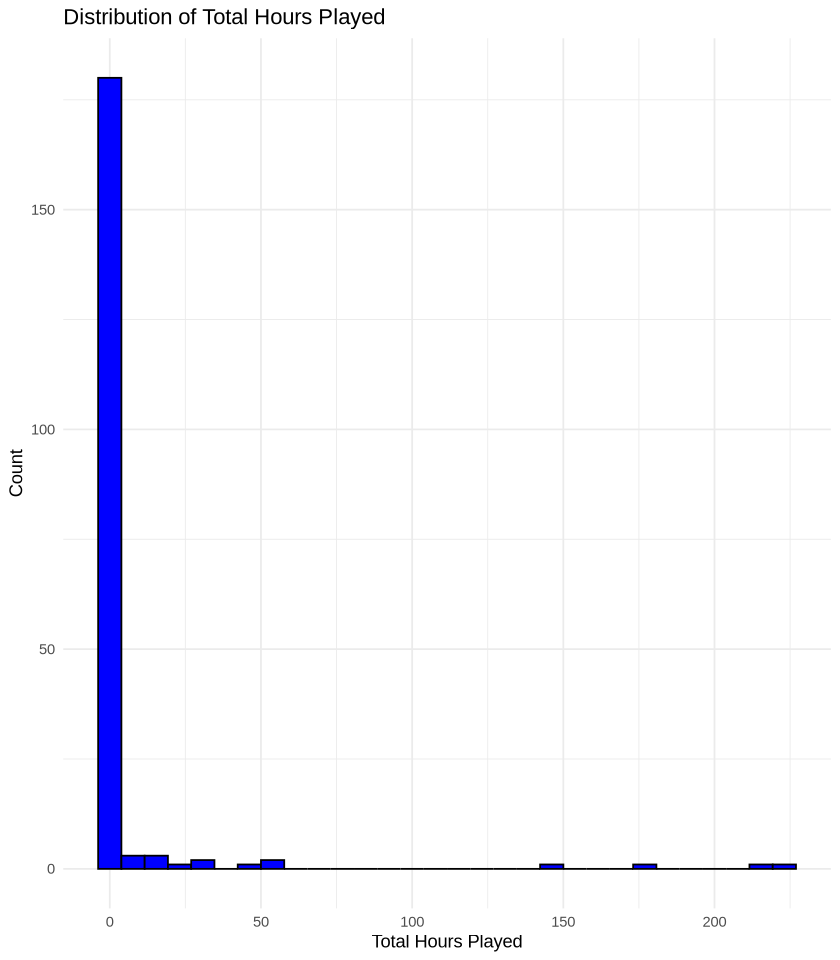

In [61]:
play_hours <- ggplot(players_filtered, aes(x = played_hours)) +
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  labs(title = "Distribution of Total Hours Played",
       x = "Total Hours Played",
       y = "Count") +
  theme_minimal()
play_hours


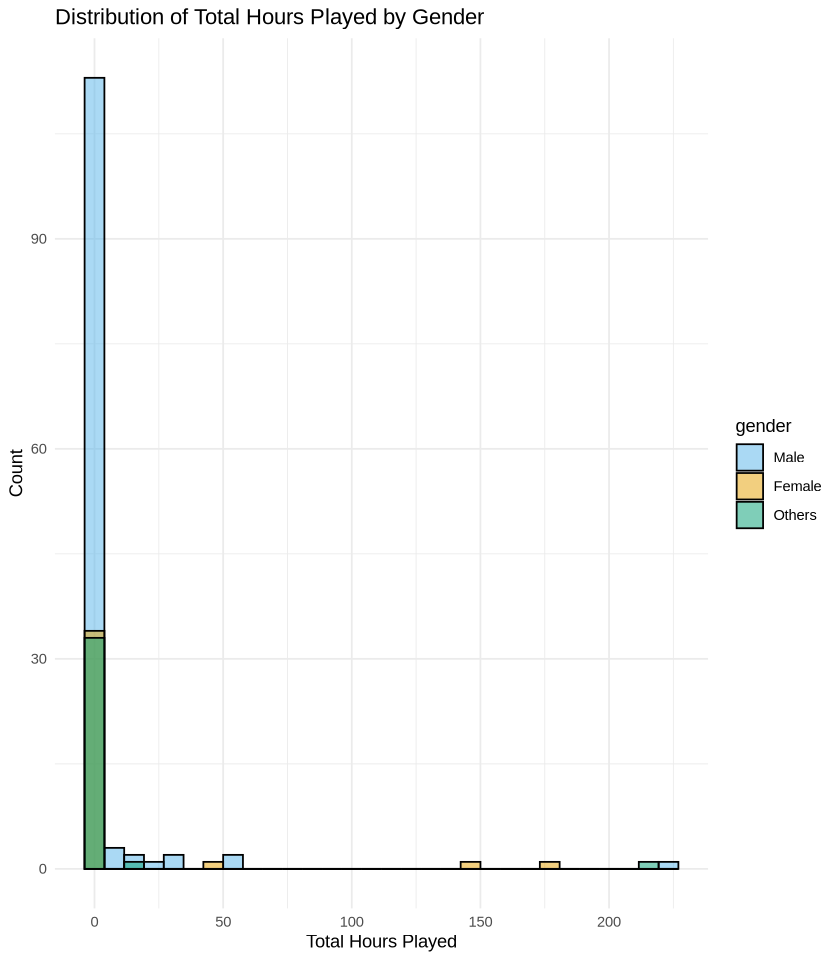

In [59]:
played_hours_hist <- ggplot(players_filtered, aes(x = played_hours, fill = gender)) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 30, color = "black") +
  scale_fill_manual(values = c("Male" = "#56B4E9", "Female" = "#E69F00", "Others" = "#009E73")) +
  labs(title = "Distribution of Total Hours Played by Gender",
       x = "Total Hours Played",
       y = "Count") +
  theme_minimal()

played_hours_hist

### Insights from the Plots
- Gender Distribution: There are roughly three times more male players than female players and other genders players in the dataset, indicating a strong imbalance in gender representation. This could influence how predictive models interpret gender-related patterns.
- Played Hours Distribution: The majority of players have logged between 0–3 hours. Very few players have played more than 50 hours, showing that most players are low-engagement users.
- Played Hours by Gender: Most players, both male and female and others, remain in the 0–3 hours range. Interestingly, there are a few female players with exceptionally high play hours above 125, though the single highest playtime is among male players. This suggests that while most female players play less, there are some highly active female users. Overall, the data is heavily right-skewed, which may affect model predictions and requires careful consideration when using KNN classification.


## 5) Methods and Plan

**Chosen Method: KNN Classification**

Select K-Nearest Neighbors (KNN) for predicting a player's gender based on their total hours played. KNN is simple, interpretable, and well-suited for binary classification tasks where the relationship between a numeric explanatory variable (played_hours) and a categorical response variable (gender) can be captured by proximity. It does not require assumptions about the data distribution, making it flexible for dataset.

**Why This Method?**

KNN is ideal for this problem because:  

- It handles non-linear relationships effectively.  
- It uses distance-based similarity, which fits the data where players with similar total hours may share the same gender.  

**Assumptions**

- Players with similar playtime patterns are likely to have the same gender.  
- The data is not excessively sparse or high-dimensional.  

**Limitations**

KNN has some drawbacks:  

- Sensitive to outliers: extreme playtime values may distort distance calculations.  
- Choice of K: a small K can overfit, and a large K can underfit. Will tune K through cross-validation.  

**Model Comparison**

Will use cross-validation to compare different values of k and evaluate models based on accuracy, precision, recall, and F1 score. The optimal K will be selected based on maximizing predictive performance.

**We do not use Linear Regression**  

1) The question that are exploring is not a linear relationship between features and the target.  
2) Binary regression methods could be considered, but we have not learned them in DSCI100.  

**Data Processing**

- **Train-Test Split:** 80% training, 20% testing.  
- **Cross-Validation:** 5-fold cross-validation to tune K.  
- **Scaling:** Standardize `played_hours` before training to improve KNN performance.  
- **Validation Set:** Final model performance will be tested on the hold-out test set.
